# NIE DZIALA

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(20030403)

In [73]:
np.random.seed(20030403)
np.set_printoptions(precision=2) # 2 decimal places for numpy

## Datasets

In [8]:
square_simple_train = pd.read_csv('../regression/square-simple-training.csv')
steps_small_train = pd.read_csv('../regression/steps-small-training.csv')
multimodal_large_train = pd.read_csv('../regression/multimodal-large-training.csv')

square_simple_test = pd.read_csv('../regression/square-simple-training.csv')
steps_small_test = pd.read_csv('../regression/steps-small-training.csv')
multimodal_large_test = pd.read_csv('../regression/multimodal-large-training.csv')


## Helper Functions

In [51]:
def plot_data(data_x, data_y):
    plt.figure(figsize=(8, 6))
    plt.scatter(data_x, data_y, color='blue', label='Dane treningowe')
    plt.xlabel("X")
    plt.ylabel("y")
    plt.title("Wykres danych treningowych")
    plt.legend()
    plt.grid()
    plt.show()

# Data plots

## square_simple_train

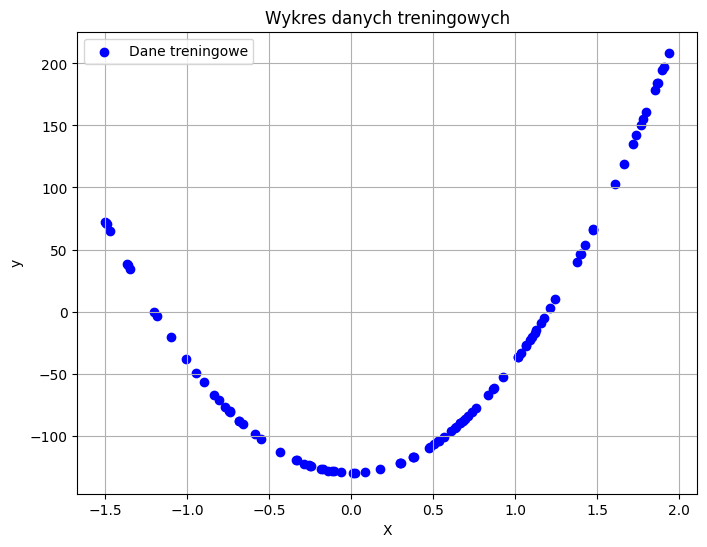

In [52]:
plot_data(square_simple_train['x'], square_simple_train['y'])

## steps_small_train

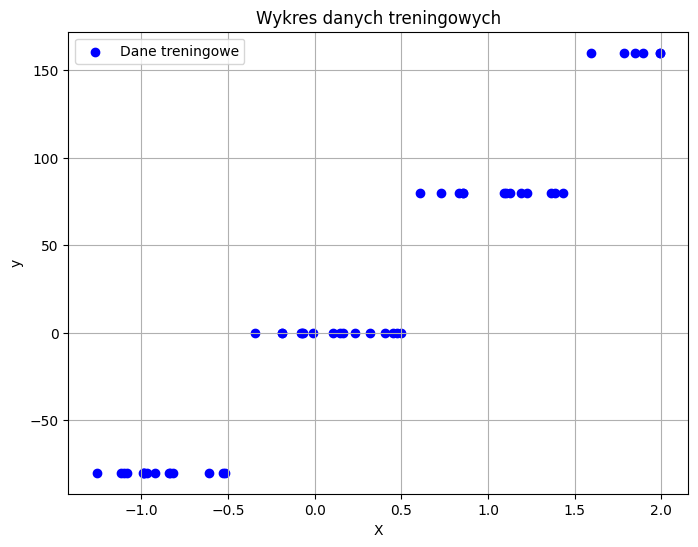

In [53]:
plot_data(steps_small_train['x'], steps_small_train['y'])

## multimodal_large_train

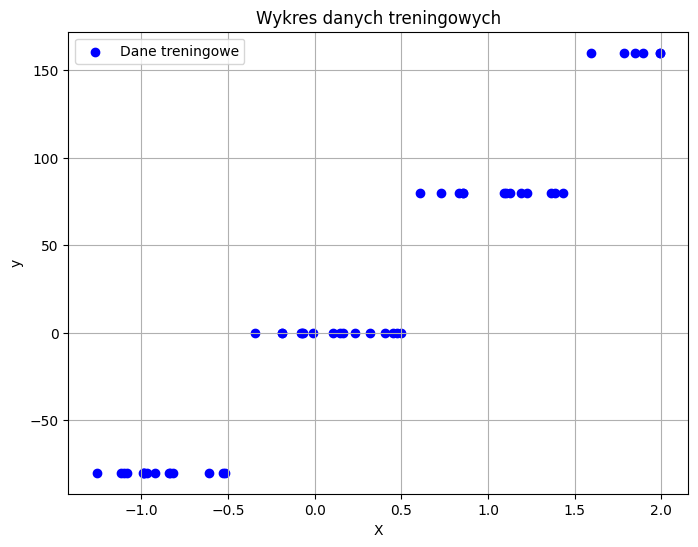

In [54]:
plot_data(steps_small_train['x'], steps_small_train['y'])

# Activator Functions

In [93]:
def linear(x, derivative=False):
    """ Liniowa funkcja aktywacji """
    if derivative:
        return 1
    return  x

def sigmoidal(x, derivative=False):
    """ sigmoidalna funkcja aktywacji """
    x = np.clip(x, -500, 500)
    s = 1 / (1 + np.exp(-x))
    if derivative:
        return s * (1 - s)
    return s

print(linear(3))
print(sigmoidal(0))

3
0.5


# MLP backprop

In [152]:
class MLPBackprop:
    def __init__(self, layers, weights = [], 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='linear', random_weights=True, random_biases=True):
        self.layers = layers
        self.weights = weights        
        self.biases = [np.zeros((n,)) for n in layers[1:]]
        activation_functions = {"linear": linear, "sigmoid": sigmoidal}

        if random_weights:
            self.weigths = [np.linspace(-1, 1, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
            # self.weights = [np.random.randn(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
        if random_biases:
            self.biases = [np.random.randn(n) for n in layers[1:]]
        else:
            # self.biases = [np.zeros(n) for n in layers[1:]]
            self.biases = [np.ones(n) for n in layers[1:]]
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)

    def forward(self, X):
        activation = X
        activations = [X]
        for i in range(len(self.weights) - 1):
            z = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation_function(z)
            activations.append(activation)
        z = activation @ self.weights[-1] + self.biases[-1]
        output = self.output_activation_function(z)
        activations.append(output)
        return activations

    def predict(self, X):
        return self.forward(X)[-1].flatten()
    
    # TODO - make it nicer - maybe layers in the middle?
    def visualize(self):
        space_between_layers = 5
        space_between_neurons = 3
        neuron_size = 0.5    
        fig, ax = plt.subplots()
        ax.set_aspect('equal') 
        
        max_neurons = max(self.layers)
        cmap = plt.get_cmap("viridis")  
        norm = plt.Normalize(0, max(self.layers) - 1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        
        for i, layer in enumerate(self.layers):
            for j in range(layer):
                ax.add_patch(plt.Circle((i * space_between_layers, j * space_between_neurons), neuron_size, color='black'))
                if i > 0:
                    for k in range(self.layers[i - 1]):
                        color = cmap(k / (self.layers[i - 1] - 1) if self.layers[i - 1] > 1 else 0.5) 
                        plt.plot([i * space_between_layers, (i - 1) * space_between_layers], 
                                 [j * space_between_neurons, k * space_between_neurons], color=color, linewidth=1.5)
        
        plt.xlim(-1, len(self.layers) * space_between_layers)
        plt.ylim(-1, max_neurons * space_between_neurons)
        plt.axis('off')

        cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
        cbar.set_label("Connection Intensity")

        plt.show()

    def update_weights(self, graidients, learning_rate = 0.01):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * graidients[i]

    # def update_biases(self, nabla, learning_rate = 0.01):
    #     for i in range(len(self.biases)):
    #         self.biases[i] -= learning_rate * nabla[i]

    def backpropagation(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        N = X.shape[0]  # Number of samples

        activations = self.forward(X)

        # Compute delta for the output layer
        delta = self.g_prim(activations[-1], y) * self.output_activation_function(activations[-1], derivative=True)
        nabla = [None] * len(self.weights)
        
        # Weight gradient for the output layer:
        nabla[-1] = activations[-2].T @ delta / N

        # Backpropagate the error for each hidden layer:
        for l in range(len(self.weights) - 2, -1, -1):
            delta = (delta @ self.weights[l+1].T) * self.hidden_activation_function(activations[l+1], derivative=True)
            nabla[l] = activations[l].T @ delta / N

        # # Optionally print shapes for debugging:
        # for grad in nabla:
        #     print(grad.shape)

        return nabla

    
    def train(self, X, y, epochs=100, learning_rate=0.01):
        for i in range(epochs):
            nabla = self.backpropagation(X, y)
            self.update_weights(nabla, learning_rate)
            # self.update_biases(nabla, learning_rate)
            if i % 10 == 0:
                print(f'Epoch {i}, MSE: {self.mse(y, self.predict(X))}')

    def g_prim(self, output_activations, y):
        return output_activations - y
  

    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def plot_results(model, X_test, y_test):

        # Compute predictions from the model
        y_pred = model.predict(X_test)
        
        # Create a scatter plot of true vs. predicted values.
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, color='red', label='Predictions')
        
        # Plot the ideal line (perfect prediction) for reference.
        min_val = min(np.min(y_test), np.min(y_pred))
        max_val = max(np.max(y_test), np.max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'b--', label='Ideal (y=x)')
        
        plt.xlabel('True y')
        plt.ylabel('Predicted y')
        plt.title('True vs Predicted Values')
        plt.legend()
        plt.show()

    

X_train, y_train = square_simple_train.iloc[:, 1:2].values, square_simple_train.iloc[:, -1].values
X_test, y_test = square_simple_test.iloc[:, 1:2].values, square_simple_test.iloc[:, -1].values

NN = MLPBackprop([1, 5, 1])
NN.train(X_train, y_train)
predictions = NN.predict(X_test)
print(NN.mse(y_test, predictions))
NN.plot_results(X_test, y_test)
# NN.backpropagation(X_train, y_train)

IndexError: list index out of range

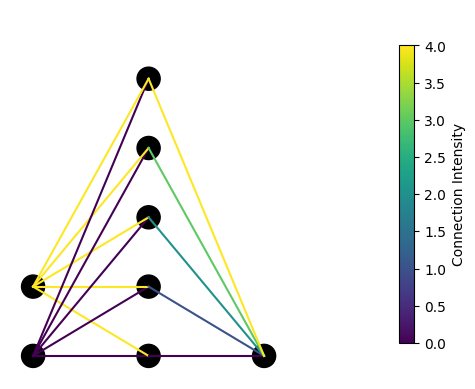

In [26]:
NN = MLPBackprop([2, 5, 1], [np.random.randn(2, 2), np.random.randn(2, 1)])
NN.visualize()

# SECOND

Epoch 0, MSE: 9919.045007457522
Epoch 10, MSE: 8255.91359196035
Epoch 20, MSE: 8292.212883725613
Epoch 30, MSE: 8356.017296409433
Epoch 40, MSE: 8393.218073773549
Epoch 50, MSE: 8419.341157312669
Epoch 60, MSE: 8458.01847580739
Epoch 70, MSE: 8477.068495632022
Epoch 80, MSE: 8482.365210490736
Epoch 90, MSE: 8483.965903659817
Epoch 100, MSE: 8484.784058949894
Epoch 110, MSE: 8485.544676388716
Epoch 120, MSE: 8486.472400244607
Epoch 130, MSE: 8487.683311677747
Epoch 140, MSE: 8489.27587932856
Epoch 150, MSE: 8491.35239989959
Epoch 160, MSE: 8494.021291266754
Epoch 170, MSE: 8497.387565046081
Epoch 180, MSE: 8501.525507070217
Epoch 190, MSE: 8506.430538396915
Epoch 200, MSE: 8511.973090283422
Epoch 210, MSE: 8517.9030364599
Epoch 220, MSE: 8523.923866467989
Epoch 230, MSE: 8529.786105946747
Epoch 240, MSE: 8535.3353334812
Epoch 250, MSE: 8540.50388618909
Epoch 260, MSE: 8545.276733677672
Epoch 270, MSE: 8549.659798129267
Epoch 280, MSE: 8553.661111386644
Epoch 290, MSE: 8557.28374441303
E

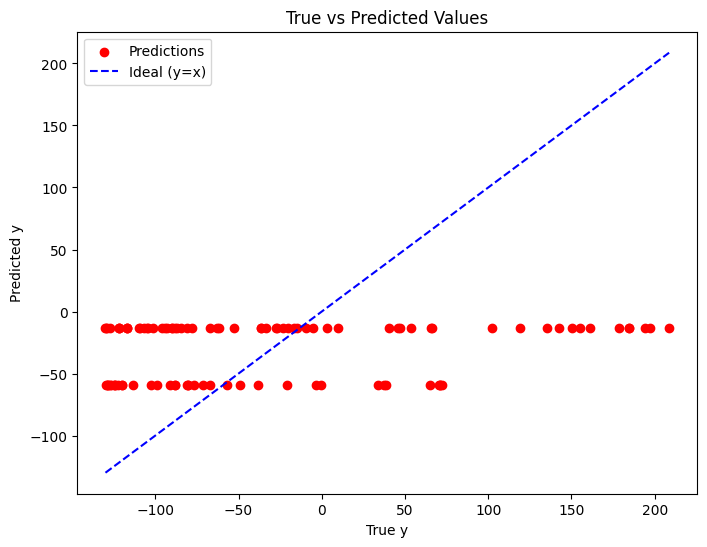

In [ ]:
class MLPBackprop:
    def __init__(self, layers, weights = [], 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='linear', random_weights=True, random_biases=True):
        self.layers = layers
        self.weights = weights        
        self.biases = [np.zeros((n,)) for n in layers[1:]]
        activation_functions = {"linear": linear, "sigmoid": sigmoidal}

        if random_weights:
            self.weights = [np.random.randn(layers[i], layers[i + 1]) for i in range(len(layers) - 1)]
        if random_biases:
            self.biases = [np.random.randn(n) for n in layers[1:]]
        else:
            self.biases
            # self.biases = [np.zeros(n) for n in layers[1:]]
            # self.biases = [np.ones(n) for n in layers[1:]]
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)

    def forward(self, X):
        activation = X
        activations = [X]  # Store activations layer by layer
        for i in range(len(self.weights) - 1):
            z = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation_function(z)
            activations.append(activation)
        # Final layer (output)
        z = activation @ self.weights[-1] + self.biases[-1]
        output = self.output_activation_function(z)
        activations.append(output)
        return activations

    def predict(self, X):
        return self.forward(X)[-1].flatten()
    
    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def backpropagation(self, X, y):
        """
        Compute gradients for all weights and biases using backpropagation.
        Based on the presentation, we use MSE as the cost function:
        
          For output layer:
              δ^L = (h^L - y) ⊙ g'(z^L)
          For hidden layers:
              δ^l = (δ^(l+1) @ (W^(l+1))^T) ⊙ f'(z^l)
          
          Gradients:
              dW^l = (h^(l-1))^T @ δ^l  (averaged over samples)
              db^l = mean(δ^l, axis=0)
        """
        # Ensure y is a column vector
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        N = X.shape[0]  # Number of samples

        # Forward pass: get all activations
        activations = self.forward(X)

        # Initialize lists for gradients for weights and biases
        grad_w = [None] * len(self.weights)
        grad_b = [None] * len(self.biases)

        # --- Output layer ---
        # δ^L = (h^L - y) * g'(z^L)
        delta = (activations[-1] - y) * self.output_activation_function(activations[-1], derivative=True)
        grad_w[-1] = (activations[-2].T @ delta) / N
        grad_b[-1] = np.mean(delta, axis=0)

        # --- Hidden layers (backpropagate) ---
        for l in range(len(self.weights) - 2, -1, -1):
            delta = (delta @ self.weights[l+1].T) * self.hidden_activation_function(activations[l+1], derivative=True)
            grad_w[l] = (activations[l].T @ delta) / N
            grad_b[l] = np.mean(delta, axis=0)

        return grad_w, grad_b
    
    def train(self, X, y, epochs=100, learning_rate=0.01):
        """
        Train the network using full-batch gradient descent.
        For each epoch, backpropagate to get gradients for weights and biases,
        then update them using the specified learning rate.
        """
        for epoch in range(epochs):
            grad_w, grad_b = self.backpropagation(X, y)
            # Update weights and biases for each layer
            for i in range(len(self.weights)):
                self.weights[i] -= learning_rate * grad_w[i]
                self.biases[i]  -= learning_rate * grad_b[i]
            # Optionally print the MSE every 10 epochs
            if epoch % 10 == 0:
                predictions = self.predict(X)
                loss = self.mse(y, predictions)
                print(f'Epoch {epoch}, MSE: {loss}')
    
    def plot_results(model, X_test, y_test):
        import matplotlib.pyplot as plt
        # Compute predictions from the model
        y_pred = model.predict(X_test)
        
        # Create a scatter plot of true vs. predicted values.
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, color='red', label='Predictions')
        
        # Plot the ideal line (perfect prediction) for reference.
        min_val = min(np.min(y_test), np.min(y_pred))
        max_val = max(np.max(y_test), np.max(y_pred))
        plt.plot([min_val, max_val], [min_val, max_val], 'b--', label='Ideal (y=x)')
        
        plt.xlabel('True y')
        plt.ylabel('Predicted y')
        plt.title('True vs Predicted Values')
        plt.legend()
        plt.show()

# Select only the "x" column for X and "y" for y (assuming your DataFrame columns are ["", "x", "y"])
X_train, y_train = square_simple_train.iloc[:, 1:2].values, square_simple_train.iloc[:, -1].values
X_test, y_test = square_simple_test.iloc[:, 1:2].values, square_simple_test.iloc[:, -1].values

# Create and train the network
NN = MLPBackprop([1, 5, 1])
NN.train(X_train, y_train, epochs=10000, learning_rate=0.03)

# Evaluate and plot results
predictions = NN.predict(X_test)
print("Final MSE:", NN.mse(y_test, predictions))
NN.plot_results(X_test, y_test)


# V3

In [ ]:
class MLPBackprop:
    def __init__(self, layers, weights, 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='linear'):
        self.layers = layers
        self.weights = weights        
        self.biases = [np.zeros((n,)) for n in layers[1:]]
        activation_functions = {"linear": linear, "sigmoid": sigmoidal}
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Zla funkcja aktywacji, wybierz z:", activation_functions)

    def forward(self, X):
        activation = X
        activations = [X]
        for i in range(len(self.weights) - 1):
            z = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation_function(z)
            activations.append(activation)
        z = activation @ self.weights[-1] + self.biases[-1]
        output = self.output_activation_function(z)
        activations.append(output)
        return activations

    def predict(self, X):
        return self.forward(X)[-1].flatten()
    
    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)


# V4

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# --- Activation functions and their derivatives ---
def linear(x):
    return x

def sigmoidal(x):
    return 1 / (1 + np.exp(-x))

# Derivative functions computed from z (the net input)
def d_linear(z):
    return np.ones_like(z)

def d_sigmoidal(z):
    s = sigmoidal(z)
    return s * (1 - s)

# --- MLP with backpropagation training ---
class MLPBackprop:
    def __init__(self, layers, weights, 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='linear'):
        self.layers = layers
        self.weights = weights        
        self.biases = [np.zeros((n,)) for n in layers[1:]]
        activation_functions = {"linear": linear, "sigmoid": sigmoidal}
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Zła funkcja aktywacji, wybierz z:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Zła funkcja aktywacji, wybierz z:", activation_functions)
    
    def forward(self, X):
        activation = X
        activations = [X]
        for i in range(len(self.weights) - 1):
            z = activation @ self.weights[i] + self.biases[i]
            activation = self.hidden_activation_function(z)
            activations.append(activation)
        z = activation @ self.weights[-1] + self.biases[-1]
        output = self.output_activation_function(z)
        activations.append(output)
        return activations

    def predict(self, X):
        return self.forward(X)[-1].flatten()
    
    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def _activation_derivative(self, z, layer='hidden'):
        # Choose derivative based on the activation used
        if layer == 'hidden':
            # Compare functions by name
            if self.hidden_activation_function.__name__ == 'sigmoidal':
                return d_sigmoidal(z)
            elif self.hidden_activation_function.__name__ == 'linear':
                return d_linear(z)
            else:
                raise NotImplementedError("Derivative not implemented for the hidden activation function.")
        elif layer == 'output':
            if self.output_activation_function.__name__ == 'sigmoidal':
                return d_sigmoidal(z)
            elif self.output_activation_function.__name__ == 'linear':
                return d_linear(z)
            else:
                raise NotImplementedError("Derivative not implemented for the output activation function.")
    
    def fit(self, X, y, learning_rate=0.01, epochs=1000, batch_size=None, verbose=False):
        """
        Train the network using backpropagation.
        
        Parameters:
            X           : input data (numpy array, shape (n_samples, n_features))
            y           : target values (numpy array, shape (n_samples,) or (n_samples, 1))
            learning_rate: learning rate for gradient descent
            epochs      : number of training epochs
            batch_size  : if None, full-batch gradient descent is used;
                          otherwise mini-batch training (e.g. batch_size=1 for stochastic)
            verbose     : if True, prints loss every 100 epochs.
        """
        if batch_size is None:
            batch_size = X.shape[0]  # full-batch update
        
        # To record weights for visualization
        self.weights_history = []
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle training data at the start of each epoch
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            
            # Process mini-batches
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                batch_indices = indices[start:end]
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                
                # ---- Forward Pass ----
                a = X_batch
                activations = [a]
                zs = []  # to store the weighted sums (pre-activation values)
                # Hidden layers
                for i in range(len(self.weights) - 1):
                    z = a @ self.weights[i] + self.biases[i]
                    zs.append(z)
                    a = self.hidden_activation_function(z)
                    activations.append(a)
                # Output layer
                z = a @ self.weights[-1] + self.biases[-1]
                zs.append(z)
                output = self.output_activation_function(z)
                activations.append(output)
                
                # ---- Backward Pass ----
                # Calculate error at output (using mean squared error derivative, factor 1 omitted)
                delta = (activations[-1] - y_batch.reshape(activations[-1].shape)) * self._activation_derivative(zs[-1], layer='output')
                deltas = [delta]
                
                # Propagate error backwards through hidden layers
                for l in range(2, len(self.layers)):
                    z = zs[-l]
                    delta = (deltas[0] @ self.weights[-l+1].T) * self._activation_derivative(z, layer='hidden')
                    deltas.insert(0, delta)
                
                # ---- Weight and Bias Update ----
                for i in range(len(self.weights)):
                    grad_w = activations[i].T @ deltas[i] / X_batch.shape[0]
                    grad_b = np.mean(deltas[i], axis=0)
                    self.weights[i] -= learning_rate * grad_w
                    self.biases[i] -= learning_rate * grad_b
            
            # Record a copy of weights after this epoch (for later visualization)
            epoch_weights = [w.copy() for w in self.weights]
            self.weights_history.append(epoch_weights)
            
            if verbose and epoch % 100 == 0:
                y_pred = self.predict(X)
                loss = self.mse(y, y_pred)
                print(f"Epoch {epoch}, Loss: {loss}")
    
    def plot_weights_history(self):
        """
        Visualize the evolution of each weight in every layer over epochs.
        """
        for layer_idx in range(len(self.weights)):
            # Flatten each weight matrix to track every weight individually
            weights_over_epochs = [epoch_weights[layer_idx].flatten() for epoch_weights in self.weights_history]
            weights_over_epochs = np.array(weights_over_epochs)
            
            plt.figure()
            for j in range(weights_over_epochs.shape[1]):
                plt.plot(weights_over_epochs[:, j], label=f'Waga {j}')
            plt.title(f'Ewolucja wag warstwy {layer_idx}')
            plt.xlabel('Epoka')
            plt.ylabel('Wartość wagi')
            plt.legend()
            plt.show()


In [154]:
# Assuming square_simple_train and square_simple_test are pandas DataFrames
X_train = square_simple_train.iloc[:, 1:2].values
y_train = square_simple_train.iloc[:, -1].values
X_test = square_simple_test.iloc[:, 1:2].values
y_test = square_simple_test.iloc[:, -1].values

# Define network architecture
layers = [X_train.shape[1], 5, 1]

# Initialize weights with uniform distribution in [0,1]
weights = [np.random.uniform(0, 1, (layers[i], layers[i+1])) for i in range(len(layers)-1)]

# Create an instance of the network
mlp = MLPBackprop(layers, weights, hidden_activation_function='sigmoid', output_activation_function='linear')


Epoch 0, Loss: 9878.181328596154
Epoch 100, Loss: 3073.1454695318366
Epoch 200, Loss: 2427.1709406427417
Epoch 300, Loss: 2308.74904837651
Epoch 400, Loss: 2284.511365535346
Epoch 500, Loss: 2273.5238159830683
Epoch 600, Loss: 2283.203789761072
Epoch 700, Loss: 2301.0115969136364
Epoch 800, Loss: 2265.6071471706887
Epoch 900, Loss: 2273.885574705918
Test Loss (full-batch): 2302.8342949471294


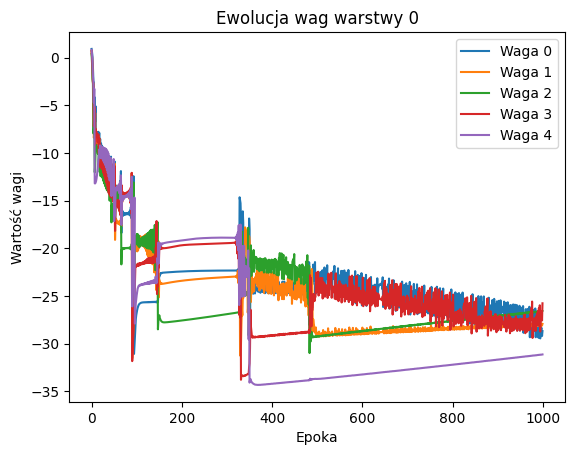

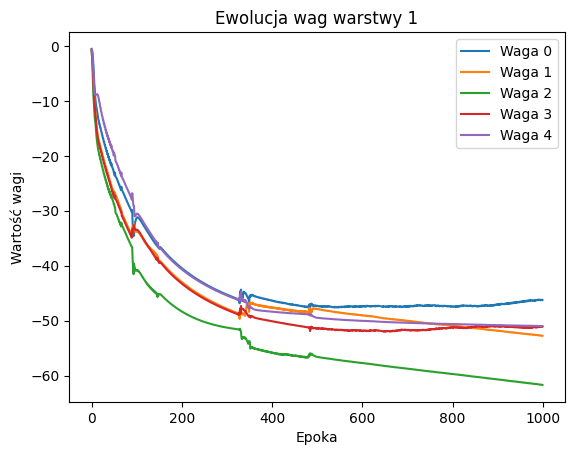

In [155]:
mlp.fit(X_train, y_train, learning_rate=0.1, epochs=1000, batch_size=X_train.shape[0], verbose=True)
y_pred = mlp.predict(X_test)
test_loss = mlp.mse(y_test, y_pred)
print("Test Loss (full-batch):", test_loss)

# Visualize the weight evolution over epochs
mlp.plot_weights_history()


Epoch 0, Loss: 8736.299285520647
Epoch 100, Loss: 6872.462898887689
Epoch 200, Loss: 9221.811622171936
Epoch 300, Loss: 9412.029016769304
Epoch 400, Loss: 9279.096343785273
Epoch 500, Loss: 9351.199639811144
Epoch 600, Loss: 9173.535881167218
Epoch 700, Loss: 9624.66522534238
Epoch 800, Loss: 9782.917369294451
Epoch 900, Loss: 9415.53471535373
Test Loss (mini-batch): 9239.06388891844


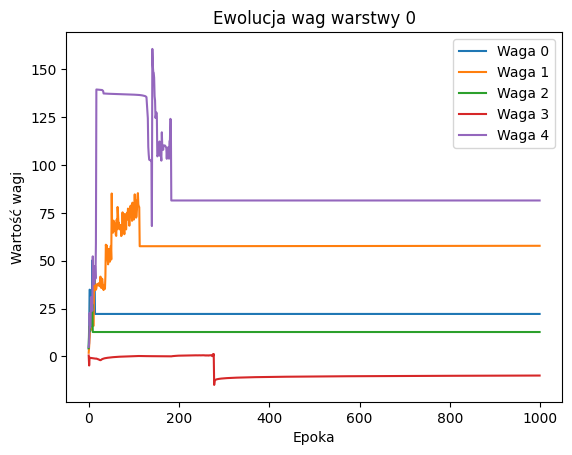

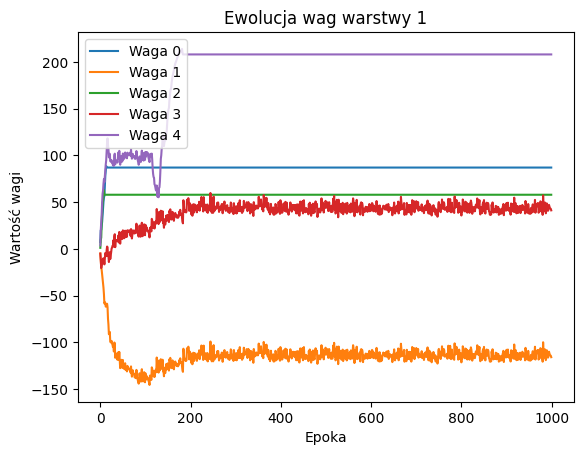

In [156]:
# Reinitialize weights
weights = [np.random.uniform(0, 1, (layers[i], layers[i+1])) for i in range(len(layers)-1)]
mlp_mini = MLPBackprop(layers, weights, hidden_activation_function='sigmoid', output_activation_function='linear')

mlp_mini.fit(X_train, y_train, learning_rate=0.1, epochs=1000, batch_size=16, verbose=True)
y_pred_mini = mlp_mini.predict(X_test)
test_loss_mini = mlp_mini.mse(y_test, y_pred_mini)
print("Test Loss (mini-batch):", test_loss_mini)

# Visualize the weight evolution over epochs
mlp_mini.plot_weights_history()
